<a href="https://colab.research.google.com/github/puneat/FuturesBacktestSystem/blob/main/BackTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/puneat/FuturesBacktestSystem.git

!cp /content/FuturesBacktestSystem/strategyClasses.py .
!cp /content/FuturesBacktestSystem/BackTest.py .
!cp /content/FuturesBacktestSystem/DataProcessing.py .

url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip3 install pyalgotrade

Cloning into 'FuturesBacktestSystem'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 119 (delta 59), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (119/119), 1.28 MiB | 3.25 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Selecting previously unselected package libta-lib0.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |█████████████

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
from __future__ import print_function
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.talibext import indicator
import matplotlib.pyplot as plt
from datetime import datetime
from pyalgotrade.barfeed.csvfeed import GenericBarFeed
from pyalgotrade.bar import Frequency
import pandas as pd
import strategyClasses
import BackTest
from DataProcessing import process_data, metrics, cumulativeReturnsPlot, savePlots, saveLogs, readBacktestResults
import talib
from talib import MA_Type
import numpy as np
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import trades
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import drawdown
from pyalgotrade import broker as basebroker
from tqdm import tqdm
import seaborn as sns; sns.set_theme()
from os import listdir
from os.path import isfile, join

# import talib
plt.rcParams['figure.figsize'] = (30.0, 15.0)

/content/DataProcessing.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
from pyalgotrade.barfeed.csvfeed import GenericBarFeed
from pyalgotrade.bar import Frequency
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import rsi
from pyalgotrade.technical import cross
from pyalgotrade.technical.bollinger import BollingerBands
from pyalgotrade.technical.macd import MACD
from pyalgotrade.technical.stoch import StochasticOscillator
from pyalgotrade.broker.backtesting import Broker
from pyalgotrade.technical.vwap import VWAP
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import trades
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import drawdown
from pyalgotrade import broker as basebroker

class ATR_talib():
    def __init__(self, #fixed
               priceDS, #fixed
               priceBarDS,  #fixed
               trixFarPeriod = 14,
               trixNearPeriod = 7): #custom
    # prices
        self.priceDS = priceDS
        self.priceBarDS = priceBarDS
        self.trixNearPeriod = trixNearPeriod
        self.trixFarPeriod = trixFarPeriod
        self.atr_ts_low = -10000
        self.atr_ts_high = 10000



    def enterLongSignal(self, extPriceBarDS, extPriceDS):
        atr = indicator.ATR( extPriceBarDS,
                            count=100,
                            timeperiod=7)
        
        atr_ts = atr[-1]*2
        if self.atr_ts_low == -10000 and self.atr_ts_high == 10000:
          self.atr_ts_low =  extPriceDS.__getitem__(0) - atr_ts
          self.atr_ts_high = extPriceDS.__getitem__(0)  + atr_ts
          longEntryFilter_1 = False

        else:
          longEntryFilter_1 = extPriceDS.__getitem__(0) > self.atr_ts_high
          self.atr_ts_low =  extPriceDS.__getitem__(0) - atr_ts
          self.atr_ts_high = extPriceDS.__getitem__(0)  + atr_ts

        return longEntryFilter_1

    def exitLongSignal(self, longPos, extPriceBarDS, extPriceDS):
        longExitFilter_1 = extPriceDS.__getitem__(0) < (self.atr_ts_high)

        longExitFilter_2 = longPos.exitActive()

        return longExitFilter_1 and not longExitFilter_2

    def enterShortSignal(self,extPriceBarDS, extPriceDS):
        atr = indicator.ATR( extPriceBarDS,
                            count=100,
                            timeperiod=7)
        
        atr_ts = atr[-1]*2
        if self.atr_ts_low == -10000 and self.atr_ts_high == 10000:
          self.atr_ts_low =  extPriceDS.__getitem__(0) - atr_ts
          self.atr_ts_high = extPriceDS.__getitem__(0)  + atr_ts
          shortEntryFilter_1 = False

        else:
          shortEntryFilter_1 = extPriceDS.__getitem__(0) < self.atr_ts_low
          self.atr_ts_low =  extPriceDS.__getitem__(0) - atr_ts
          self.atr_ts_high = extPriceDS.__getitem__(0)  + atr_ts

        return shortEntryFilter_1

    def exitShortSignal(self, shortPos, extPriceBarDS, extPriceDS):

        shortExitFilter_1 = extPriceDS.__getitem__(0) > (self.atr_ts_low)
        shortExitFilter_2 = shortPos.exitActive()


        return shortExitFilter_1 and not shortExitFilter_2

In [4]:
def testStrategy(plot, path):
    instrument = 'ZS'
    # Load the bars.
    feed = GenericBarFeed(Frequency.TRADE, timezone=None, maxLen=1300000)
    feed.setDateTimeFormat("%Y-%m-%d %H:%M:%S")
    #feed.addBarsFromCSV(instrument,'/content/FuturesBacktestSystem/data/ZS_C1_15m.csv')
    feed.addBarsFromCSV(instrument, path,)
    #feed.addBarsFromCSV(instrument,'/content/ZS_C1C2_15m_shifted')
    priceDS = feed[instrument].getPriceDataSeries()
    priceBarDS = feed.getDataSeries(instrument)

    #create desired strategy class object
    strat = strategyClasses.BO_RSI_SO_talib(priceDS,
                           priceBarDS,
                           bBandsPeriod = 14,
                           rsiPeriod = 7,
                           soPeriod = 7,
                           soDPeriod=3,
                           overBoughtThreshold = 70,
                           overSoldThreshold = 30,
                           numStdDev = 2)
    
    # strat = ATR_talib(priceDS,
    #                    priceBarDS,
    #                    trixFarPeriod = 14,
    #                    trixNearPeriod = 7)

    # pass strategy to backtest system
    back = BackTest.BacktestSystem(feed,
                          instrument = instrument,
                          strategyClass = strat,
                          payupTicks = 0,
                          stopLossTicks = 4,
                          tickValue = 0.25,
                          startingMoney = 100000, # in cents
                          GTC = False,
                          AON = False,
                          lotSize = 1,
                          printOrders = False,
                          saveTradeLog = True)
    
    # attach return analyzer
    retAnalyzer = returns.Returns(maxLen=13000000)
    back.attachAnalyzer(retAnalyzer)

    tradeAnalyzer = trades.Trades()
    back.attachAnalyzer(tradeAnalyzer)

    sharpeAnalyzer = sharpe.SharpeRatio()
    back.attachAnalyzer(sharpeAnalyzer)

    drawdownAnalyzer = drawdown.DrawDown()
    back.attachAnalyzer(drawdownAnalyzer )

    if plot:
        plt = plotter.StrategyPlotter(back, True, True, False)
        # plt.getInstrumentSubplot(instrument).addDataSeries("upper", strat.bbands.getUpperBand())
        # plt.getInstrumentSubplot(instrument).addDataSeries("middle", strat.bbands.getMiddleBand())
        # plt.getInstrumentSubplot(instrument).addDataSeries("lower", strat.bbands.getLowerBand())

    cumRet = retAnalyzer.getCumulativeReturns()

    back.run()
    # back.info("Final portfolio value: $%.2f" % back.getResult())

    # print("Strategy P&L: Ticks", (back.getResult()-back.startingMoney)/back.tickValue)
    # print("Total Trades: ", (tradeAnalyzer.getCount()))
    # print("Unprofitable Trades: ", (tradeAnalyzer.getUnprofitableCount()))
    # print("Profitable Trades: ", (tradeAnalyzer.getProfitableCount()))
    # print("Break-Even Trades: ", (tradeAnalyzer.getEvenCount()))

    log_df = metrics(tradeAnalyzer, back, sharpeAnalyzer, drawdownAnalyzer, retAnalyzer)

    trades_pnl = tradeAnalyzer.getAll()
    trades_ret = tradeAnalyzer.getAllReturns()

    if plot:
        plt.plot()
        cumulativeReturnsPlot(cumRet)

    if back.saveTradeLog:
        return trades_pnl, trades_ret, cumRet, log_df, back.trade_log
    else:
        return trades_pnl, trades_ret, cumRet, log_df

In [21]:
pnl, ret, cum_ret, logs = testStrategy(False, path = '/gdrive/My Drive/Data/30min/Mar17.csv')

In [5]:
# mypath = '/gdrive/My Drive/Data/1min/'
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = ['Mar15.csv','May15.csv','Jul15.csv','Aug15.csv','Sep15.csv','Nov15.csv',
'Jan16.csv','Mar16.csv','May16.csv','Jul16.csv','Aug16.csv','Sep16.csv','Nov16.csv',
'Jan17.csv','Mar17.csv','May17.csv','Jul17.csv','Aug17.csv','Sep17.csv','Nov17.csv',
'Jan18.csv','Mar18.csv','May18.csv','Jul18.csv','Aug18.csv','Sep18.csv','Nov18.csv',
'Jan19.csv','Mar19.csv','May19.csv','Jul19.csv','Aug19.csv','Sep19.csv','Nov19.csv',
'Jan20.csv','Mar20.csv','May20.csv','Jul20.csv','Aug20.csv','Sep20.csv','Nov20.csv',
'Jan21.csv','Mar21.csv','May21.csv','Jul21.csv','Aug21.csv']

all_df = {}
p_list = ['30min']
for per in p_list:
  print(per)
  all_df = {}
  mypath = '/gdrive/My Drive/Data/' + per +'/'
  for i in tqdm(range(0, len(onlyfiles))):
    input_path = mypath + onlyfiles[i]
    pnl, ret, cum_ret, logs, trade_signals  = testStrategy(False, path = input_path)

  # save_path = '/gdrive/My Drive/Data/BORSISO/' + onlyfiles[i]
  # logs.to_csv(save_path)
  
    all_df[onlyfiles[i].split('.')[0]] = logs

    signal_df = saveLogs(trade_signals, save_path= '/gdrive/My Drive/Data/BORSISO/trade_signals/',
                         input_path = input_path,
                         contract_name = onlyfiles[i],
                         returnSignals=True)
    
    savePlots(cum_ret, '/gdrive/My Drive/Data/BORSISO/trade_signals/',
              per,
              onlyfiles[i])

trade_df = pd.DataFrame(all_df)
trade_df.to_csv('/gdrive/My Drive/Data/BORSISO/backtest_result_test_payup0_'+ per + 's.csv')

  0%|          | 0/46 [00:00<?, ?it/s]

30min


2021-03-03 21:53:04,550 numexpr.utils [INFO] NumExpr defaulting to 2 threads.
100%|██████████| 46/46 [02:37<00:00,  3.42s/it]


In [ ]:
import numpy as np

vals = np.unique(pnl,return_counts=True)

plt.bar(vals[0],vals[1], width=0.5)

In [ ]:
for i in range(0,len(pnl)):
  if pnl[i]>0:
    plt.bar(i,pnl[i], color='green')

  if pnl[i]<0:
    plt.bar(i,pnl[i], color='red')

  if pnl[i]==0:
    plt.bar(i,pnl[i], color='black')

plt.show()

In [6]:
resultsDf =  readBacktestResults('/gdrive/My Drive/Data/BORSISO/backtest_result_30mins.csv')

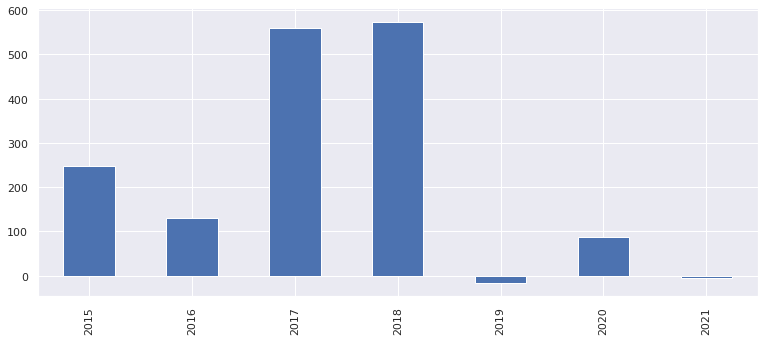

In [7]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
resultsDf['P/L Ticks'].groupby(resultsDf.index.year).mean().plot(kind='bar')

In [ ]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
res['P/L Ticks'].plot(kind='bar')

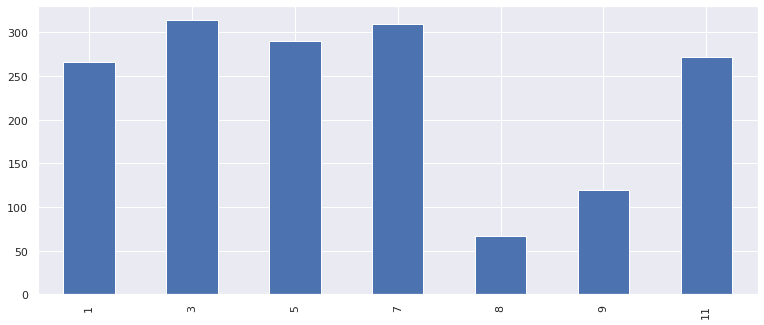

In [ ]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
res['P/L Ticks'].groupby(res.index.month).mean().plot(kind='bar')